In [1]:
from horseshoe_gibbs import sample_gibbs, sample_gibbs_improved, sample_gibbs_job
import torch
import matplotlib.pyplot as plt
from itertools import product

In [2]:
n = 100
p = 100
max_mcs = 5000

torch.manual_seed(0)
X = torch.randn(n, p)
w = torch.randn(p) * torch.bernoulli(torch.ones(p) * 0.1)
y = X @ w + torch.randn(n) * 0.1

In [3]:
torch.manual_seed(0)

results_naive = sample_gibbs(X, y, max_mcs, n_warmup=0)

Warmup  : : 0it [00:00, ?it/s]


Sampling: 100%|██████████| 5000/5000 [00:02<00:00, 1931.80it/s]


In [4]:
torch.manual_seed(0)

results_improved = sample_gibbs_improved(X, y, max_mcs, n_warmup=0)

Warmup  : : 0it [00:00, ?it/s]
Sampling: 100%|██████████| 5000/5000 [00:02<00:00, 2037.82it/s]


In [5]:
torch.manual_seed(0)

results_job = sample_gibbs_job(X, y, max_mcs, n_warmup=0)

Warmup  : : 0it [00:00, ?it/s]
Sampling: 100%|██████████| 5000/5000 [00:03<00:00, 1362.25it/s]


In [6]:
def RMSELoss(y: torch.Tensor, y_pred: torch.Tensor) -> torch.Tensor:
    y = y.reshape(-1, 1)
    if y_pred.ndim == 1:
        return torch.sqrt(torch.mean((y - y_pred) ** 2))
    return torch.sqrt(torch.mean((y - y_pred) ** 2, dim=0))


(
    beta_hist_naive,
    sigma2_hist_naive,
    tau2_hist_naive,
    lamb2_hist_naive,
) = results_naive

(
    beta_hist_improved,
    sigma2_hist_improved,
    tau2_hist_improved,
    lamb2_hist_improved,
) = results_improved

(
    beta_hist_job,
    sigma2_hist_job,
    tau2_hist_job,
    lamb2_hist_job,
) = results_job

sigma_hist_naive = torch.sqrt(sigma2_hist_naive)
y_estim_hist_naive = torch.einsum("ij,kj->ik", X, beta_hist_naive)
RMSE_naive = RMSELoss(y, y_estim_hist_naive)

sigma_hist_improved = torch.sqrt(sigma2_hist_improved)
y_estim_hist_improved = torch.einsum("ij,kj->ik", X, beta_hist_improved)
RMSE_improved = RMSELoss(y, y_estim_hist_improved)

sigma_hist_job = torch.sqrt(sigma2_hist_job)
y_estim_hist_job = torch.einsum("ij,kj->ik", X, beta_hist_job)
RMSE_job = RMSELoss(y, y_estim_hist_job)

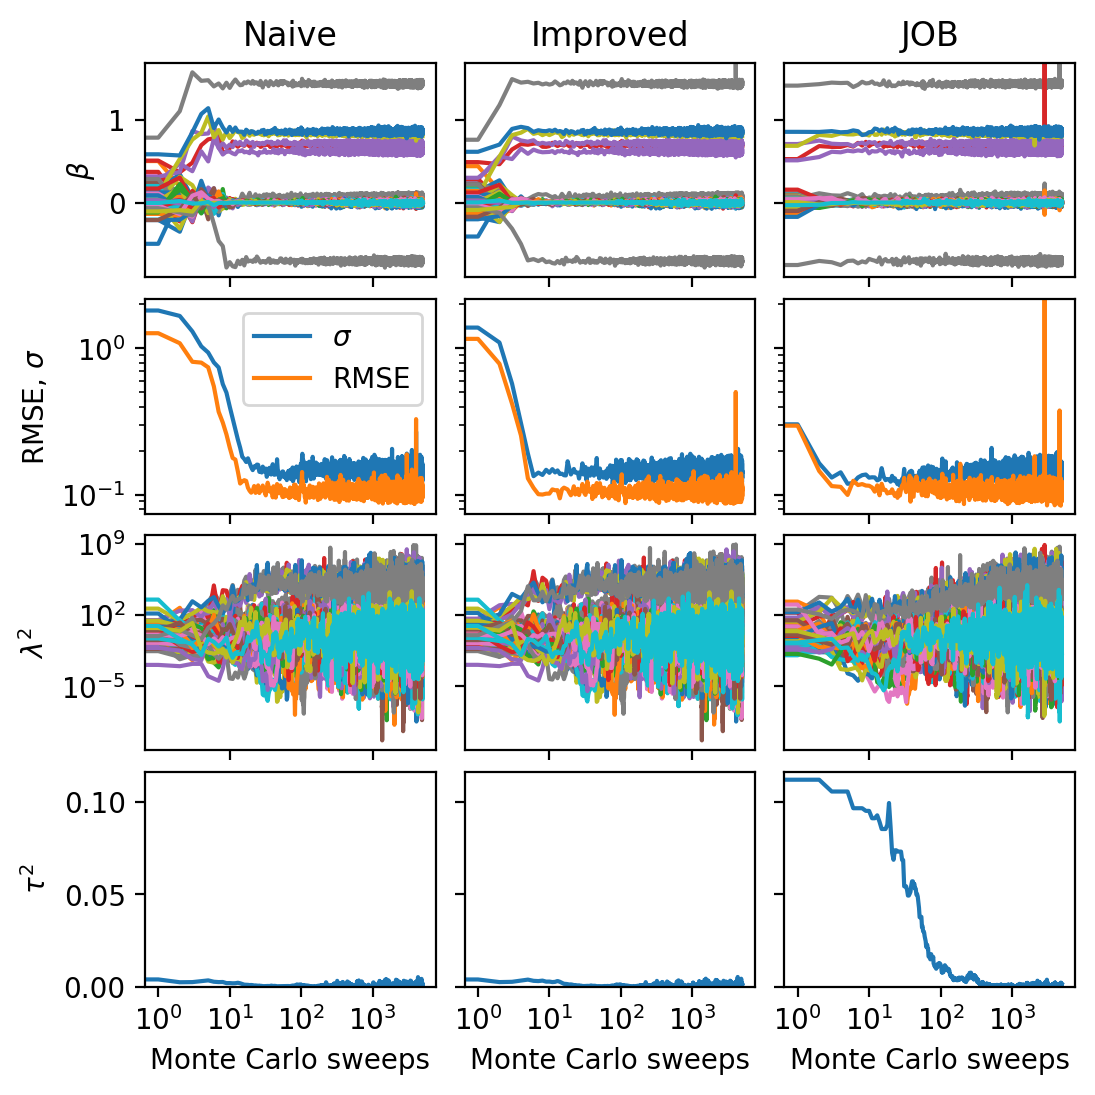

In [7]:
fig, axes = plt.subplots(4, 3, figsize=(6, 6), dpi=200)
fig.subplots_adjust(hspace=0.1, wspace=0.1)

beta_abs_max = torch.max(torch.abs(beta_hist_improved))
axes[0][0].plot(beta_hist_naive)
axes[0][1].plot(beta_hist_improved)
axes[0][2].plot(beta_hist_job)
axes[0][0].set_ylabel(r"$\beta$")

axes[1][0].plot(sigma_hist_naive, label=r"$\sigma$")
axes[1][1].plot(sigma_hist_improved, label=r"$\sigma$")
axes[1][2].plot(sigma_hist_job, label=r"$\sigma$")
axes[1][0].plot(RMSE_naive, label=r"RMSE")
axes[1][1].plot(RMSE_improved, label=r"RMSE")
axes[1][2].plot(RMSE_job, label=r"RMSE")
axes[1][0].set_ylabel(r"RMSE, $\sigma$")
axes[1][0].legend()

axes[2][0].plot(lamb2_hist_naive)
axes[2][1].plot(lamb2_hist_improved)
axes[2][2].plot(lamb2_hist_job)
axes[2][0].set_ylabel(r"$\lambda^2$")

axes[3][0].plot(tau2_hist_naive)
axes[3][1].plot(tau2_hist_improved)
axes[3][2].plot(tau2_hist_job)
axes[3][0].set_ylabel(r"$\tau^2$")

axes[0][0].set_title("Naive")
axes[0][1].set_title("Improved")
axes[0][2].set_title("JOB")

nrows = axes.shape[0]
ncols = axes.shape[1]
for row, col in product(range(nrows), range(ncols)):
    is_left = col == 0
    is_right = col == ncols - 1
    is_top = row == 0
    is_bottom = row == nrows - 1

    axes[row][col].set_xscale("log")

    if is_bottom:
        axes[row][col].set_xlabel("Monte Carlo sweeps")
        axes[row][col].set_xticks([1, 10, 100, 1000])
    if not is_top:
        axes[row][col].set_xlim(axes[0][col].get_xlim())
    if not is_left:
        axes[row][col].set_ylim(axes[row][0].get_ylim())

    if not is_top:
        axes[row][col].set_yscale("log")
    if is_bottom:
        axes[row][col].set_yscale("linear")
        axes[row][col].set_ylim(
            0,
            max(
                torch.max(tau2_hist_job),
                torch.max(tau2_hist_improved),
                torch.max(tau2_hist_naive),
            ),
        )

    if not is_bottom:
        axes[row][col].set_xticklabels([])
    if not is_left:
        axes[row][col].set_yticklabels([])

plt.show()